Populating the interactive namespace from numpy and matplotlib



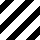
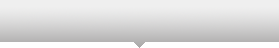
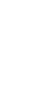
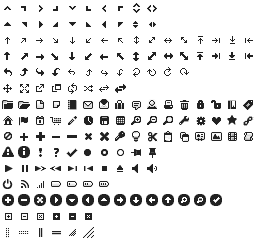
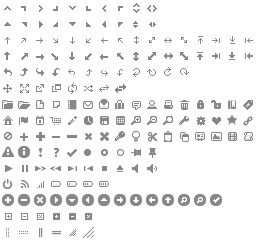
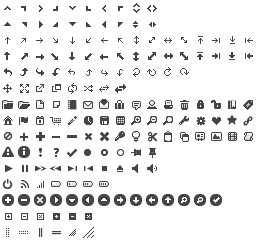
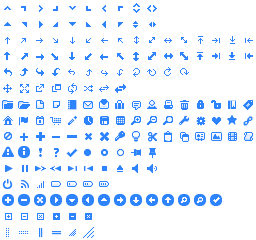
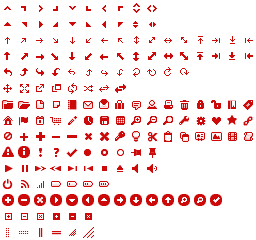
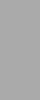
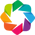
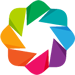
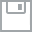
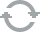
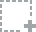
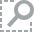
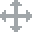
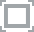
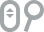

In [1]:
%matplotlib inline
%pylab inline
# data manipulation and modeling
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas.stats.moments import ewma, ewmcorr
from sklearn import datasets, linear_model
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, KFold
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import Ridge, Lasso

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

# graphix
import matplotlib.pyplot as plt
import prettyplotlib as pplt
import seaborn as sns
import statsmodels.graphics.tsaplots as tsaplots

from bokeh.plotting import figure,gridplot,show,output_notebook
from bokeh.models import Range1d
output_notebook()

# utility
import os
import math

# notebook parameters
pd.set_option('display.max_columns', 40) # number of columns in training set
plt.rcParams['figure.figsize'] = (25.0, 25.0)

In [2]:
training_data = pd.read_csv("TrainingSet.csv", index_col=0)
submission_labels = pd.read_csv("SubmissionRows.csv", index_col=0)

In [4]:
#training_data.head(100)

In [5]:
#submission_labels.head()

In [6]:
#training_data.loc[559]

In [55]:
def generate_year_list(start, stop=None):
    """ 
    make a list of column names for specific years
    in the format they appear in the data frame start/stop inclusive
    """

    if isinstance(start, list):
        data_range = start
    elif stop:
        data_range = range(start, stop+1)
    else:
        data_range = [start]
    
    yrs = []
    
    for yr in data_range:
        yrs.append("{0} [YR{0}]".format(yr))
        
    return yrs

# ========== TEST CASES =======
# one year
print generate_year_list(2008)

# start and stop (inclusive)
print generate_year_list(1985, 1990)

# custom year list
print generate_year_list([1985, 1990])

['2008 [YR2008]']
['1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]', '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]']
['1985 [YR1985]', '1990 [YR1990]']


In [56]:
prediction_rows = training_data.loc[submission_labels.index]
#prediction_rows

In [57]:
prediction_rows = prediction_rows[generate_year_list(1972, 2007)]
#prediction_rows

In [10]:
#prediction_rows.info()

In [59]:
np.random.seed(10)
rand_rows = np.random.choice(prediction_rows.index.values, size=10)

def plot_rows(data, ids=None):
#     bmap = pplt.brewer2mpl.get_map('Set3','Qualitative', 10)
#     colors = bmap.mpl_colors
    
    if not None == ids:
        get_rows = lambda: enumerate(ids)
    else:
        get_rows = lambda: enumerate(data.index.values)
    
    for i,r in get_rows():
        time_data = data.loc[r]

        just_years = [y[:4] for y in data.columns]
        X = pd.DatetimeIndex(just_years)
        country, descrip = training_data[["Country Name", "Series Name"]].loc[r]

        p = figure(title="{} - {}".format(country, descrip),plot_width=500, plot_height=200,title_text_font_size='6pt')
        p.line(X, time_data,alpha=.4, line_width=2)
        p.scatter(X, time_data, alpha=0.4,)
        show(p)
plot_rows(prediction_rows, ids=rand_rows)

P:\Anaconda Python\Anaconda\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


P:\Anaconda Python\Anaconda\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


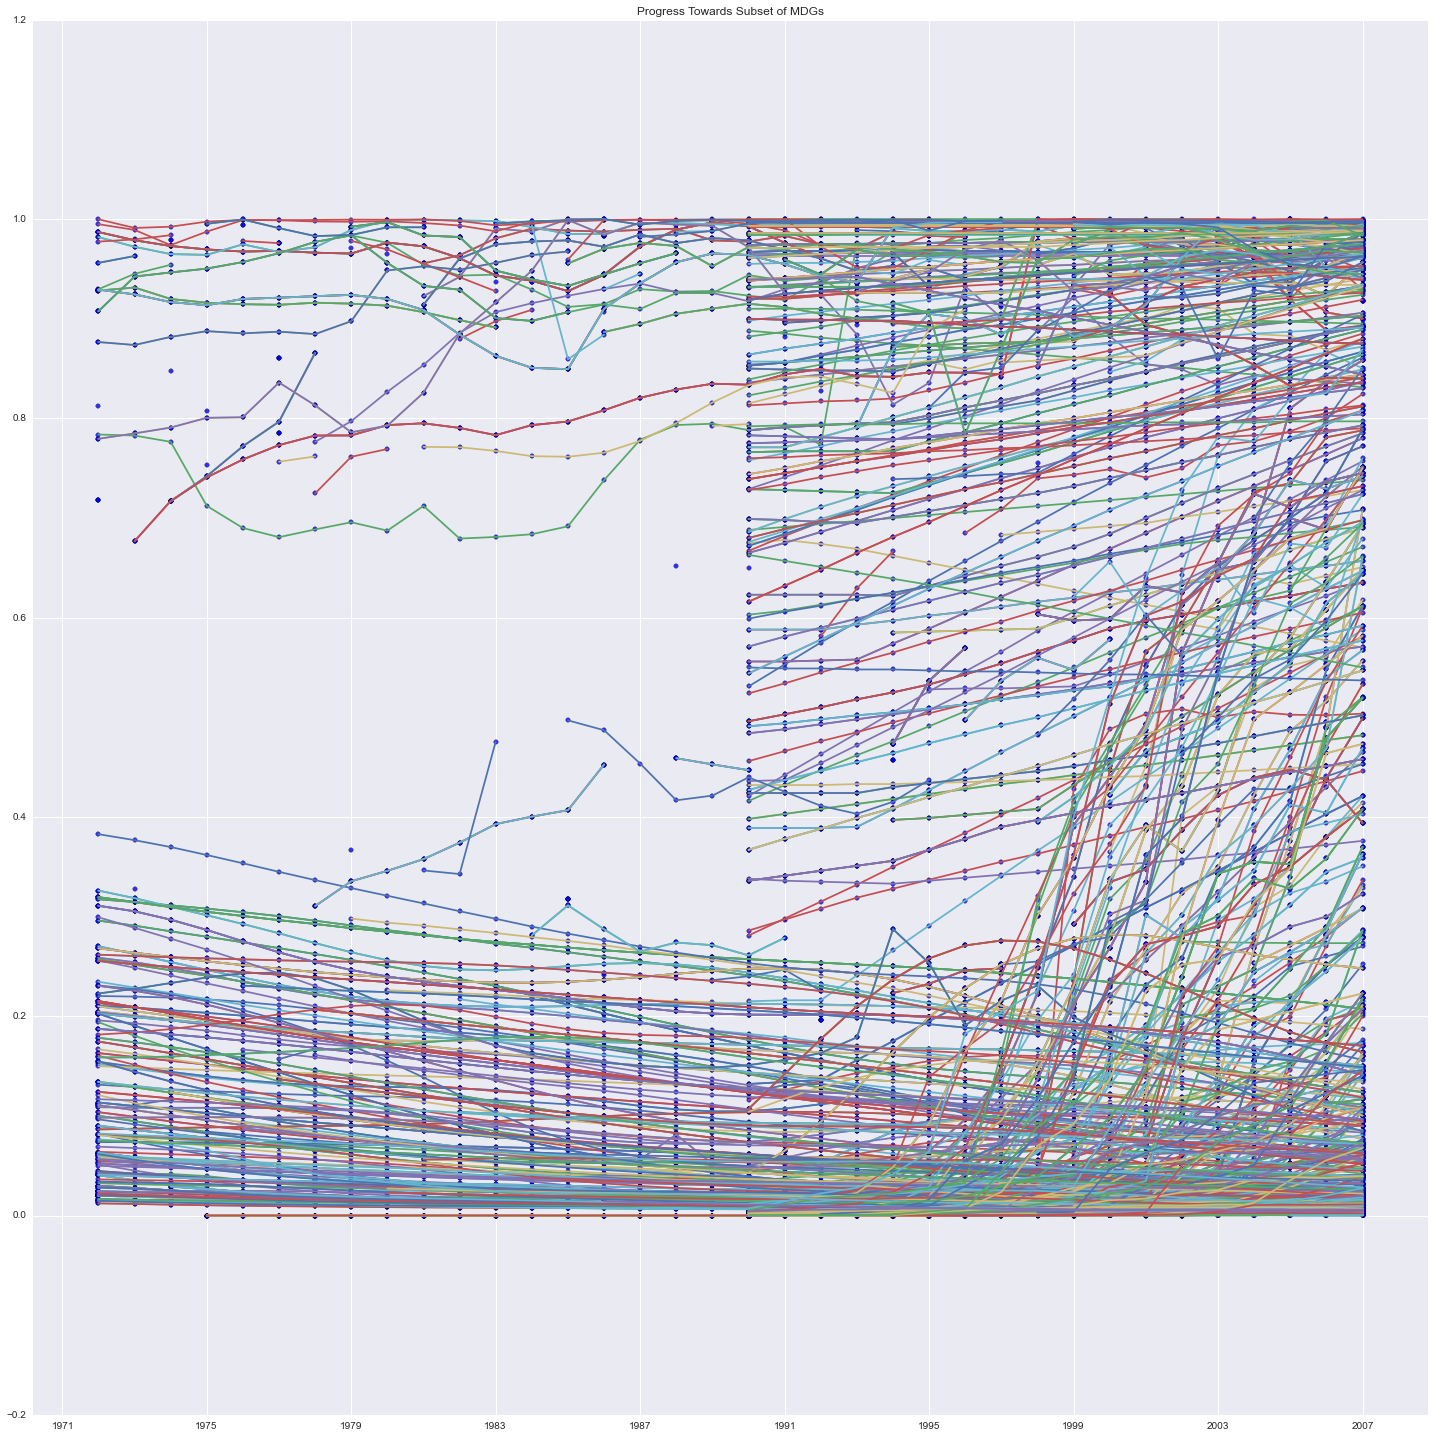

In [58]:
# grab a random sample of 10 of the timeseries
np.random.seed(100)
rand_rows = np.random.choice(prediction_rows.index.values, size=1000)

def plot_rows(data, ids=None, linestyle="-", legend=True):
    # get some colors for the lines
    bmap = pplt.brewer2mpl.get_map('Set3','Qualitative', 10, True)
    #colors = bmap.mpl_colors
    
    if not None == ids:
        get_rows = lambda: enumerate(ids)
    else:
        get_rows = lambda: enumerate(data.index.values)
    
    for i, r in get_rows():
        # get the time series values
        time_data = data.loc[r]

        # create an x axis to plot along
        just_years = [y[:4] for y in data.columns]
        X = pd.DatetimeIndex(just_years)

        # get time series info for labeling
        country, descrip = training_data[["Country Name", "Series Name"]].loc[r]

        # plot the series
        plt.plot(X, time_data, 
                 label="{} - {}".format(country, descrip), ls=linestyle)
        plt.scatter(X, time_data, alpha=0.8)

#     if legend:
#         plt.legend(loc=0)
    plt.title("Progress Towards Subset of MDGs")

plot_rows(prediction_rows, ids=rand_rows)
plt.show()

In [60]:
#"Country Name" = "India"
country_data = training_data[training_data["Country Name"] == 'India']
country_values = country_data[generate_year_list(1972, 2007)].values
#country_data.info()

In [14]:
# country_data

In [15]:
# country_values

In [61]:
countrydata = training_data.groupby("Country Name")

In [64]:
#data for country India containing Null Values
india = countrydata.get_group("India")
india

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
114990            NaN            NaN            NaN            NaN   
114991            NaN            NaN            NaN            NaN   
114992            NaN            NaN            NaN            NaN   
114993            NaN            NaN            NaN            NaN   
114994            NaN            NaN            NaN            NaN   
114995            NaN            NaN            NaN            NaN   
114996            NaN            NaN            NaN            NaN   
114998            NaN            NaN            NaN            NaN   
114999            NaN            NaN            NaN            NaN   
115000            NaN            NaN            NaN            NaN   
115001  -6.697895e-01   2.313600e+00  -1.531138e+00   6.592208e+00   
115002   1.396281e+11   1.428585e+11   1.406712e+11   1.499445e+11   
115003   6.563329e+10   7.828323e+10   9.029951e+10   8.772904e+10   
115004  -2.892019e+00   7.264818e-03  -3.767668e+00   4.154560e+00   
115005   2.404070e+02   2.404245e+02   2.313661e+02   2.409783e+02   
115006   1.130052e+02   1.317471e+02   1.485183e+02   1.409908e+02   
115007            NaN            NaN            NaN   7.396319e+00   
115008            NaN            NaN            NaN   7.389280e+09   
115009            NaN            NaN            NaN            NaN   
115010            NaN            NaN            NaN            NaN   
115011   4.436005e-01   4.074197e-01   3.990409e-01   4.852030e-01   
115012   3.208382e+08   3.528321e+08   4.026587e+08   4.847412e+08   
115013   7.216497e+00   6.914325e+00   7.479669e+00   8.051765e+00   
115014   5.219399e+09   5.987917e+09   7.547481e+09   8.044102e+09   
115015   2.410000e+00   2.418340e+00   2.561091e+00   2.209960e+00   
115016   1.743055e+09   2.094322e+09   2.584310e+09   2.207857e+09   
115017   2.103407e-01   2.453361e-01   6.697881e-01   1.119286e+00   
115018   1.521309e+08   2.124651e+08   6.758606e+08   1.118221e+09   
115019            NaN            NaN            NaN   1.785896e+01   
115020   1.366612e-01   1.174164e-01   1.478037e-01   2.041325e-01   
...               ...            ...            ...            ...   
116278            NaN            NaN            NaN            NaN   
116279            NaN            NaN            NaN            NaN   
116280            NaN            NaN            NaN            NaN   
116281            NaN            NaN            NaN            NaN   
116282            NaN            NaN            NaN            NaN   
116283            NaN            NaN            NaN            NaN   
116284            NaN            NaN            NaN            NaN   
116285            NaN            NaN            NaN            NaN   
116286            NaN            NaN            NaN            NaN   
116287   1.184179e+08   1.230170e+08   1.277875e+08   1.327346e+08   
116288   2.038880e+01   2.070320e+01   2.101760e+01   2.133200e+01   
116289   3.816655e+00   3.810233e+00   3.804689e+00   3.798258e+00   
116290   0.000000e+00   7.479700e+07   6.085150e+08   8.175230e+08   
116292            NaN            NaN            NaN            NaN   
116294            NaN            NaN            NaN            NaN   
116295            NaN            NaN            NaN            NaN   
116296            NaN            NaN            NaN            NaN   
116297            NaN            NaN            NaN            NaN   
116298            NaN            NaN            NaN            NaN   
116299            NaN            NaN            NaN            NaN   
116300            NaN            NaN            NaN            NaN   
116301            NaN            NaN            NaN            NaN   
116310            NaN            NaN            NaN            NaN   
116311   6.458208e+00   7.518547e+00   9.666839e+00   1.004536e+01   
116313            NaN            NaN            NaN            NaN   
116314            

In [65]:
india_values = india[generate_year_list(1972, 2007)].values
india_values

array([[         nan,          nan,          nan, ...,  10.72211477,
                 nan,          nan],
       [         nan,          nan,          nan, ...,  39.98927274,
                 nan,          nan],
       [         nan,          nan,          nan, ...,  28.40343153,
                 nan,          nan],
       ..., 
       [         nan,          nan,          nan, ...,          nan,
         34.7       ,          nan],
       [         nan,          nan,          nan, ...,          nan,
         14.1       ,          nan],
       [         nan,          nan,          nan, ...,  36.8       ,
         37.2       ,  37.5       ]])

In [66]:
india2 = countrydata.get_group("India")

In [67]:
india2[india2.columns[:36]] = india2[india2.columns[:36]].fillna(method = 'bfill', axis = 1)
#india2

P:\Anaconda Python\Anaconda\lib\site-packages\pandas\core\frame.py:2148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [68]:
india2[india2.columns[:36]] = india2[india2.columns[:36]].fillna(method = 'ffill', axis = 1)
india2.head()

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
114990      10.722115      10.722115      10.722115      10.722115   
114991      39.989273      39.989273      39.989273      39.989273   
114992      28.403432      28.403432      28.403432      28.403432   
114993       3.995493       3.995493       3.995493       3.995493   
114994      14.668542      14.668542      14.668542      14.668542   

        1976 [YR1976]  1977 [YR1977]  1978 [YR1978]  1979 [YR1979]  \
114990      10.722115      10.722115      10.722115      10.722115   
114991      39.989273      39.989273      39.989273      39.989273   
114992      28.403432      28.403432      28.403432      28.403432   
114993       3.995493       3.995493       3.995493       3.995493   
114994      14.668542      14.668542      14.668542      14.668542   

        1980 [YR1980]  1981 [YR1981]  1982 [YR1982]  1983 [YR1983]  \
114990      10.722115      10.722115      10.722115      10.722115   
114991      39.989273      39.989273      39.989273      39.989273   
114992      28.403432      28.403432      28.403432      28.403432   
114993       3.995493       3.995493       3.995493       3.995493   
114994      14.668542      14.668542      14.668542      14.668542   

        1984 [YR1984]  1985 [YR1985]  1986 [YR1986]  1987 [YR1987]  \
114990      10.722115      10.722115      10.722115      10.722115   
114991      39.989273      39.989273      39.989273      39.989273   
114992      28.403432      28.403432      28.403432      28.403432   
114993       3.995493       3.995493       3.995493       3.995493   
114994      14.668542      14.668542      14.668542      14.668542   

        1988 [YR1988]  1989 [YR1989]  1990 [YR1990]  1991 [YR1991]  \
114990      10.722115      10.722115      10.722115      10.722115   
114991      39.989273      39.989273      39.989273      39.989273   
114992      28.403432      28.403432      28.403432      28.403432   
114993       3.995493       3.995493       3.995493       3.995493   
114994      14.668542      14.668542      14.668542      14.668542   

        1992 [YR1992]  1993 [YR1993]  1994 [YR1994]  1995 [YR1995]  \
114990      10.722115      10.722115      10.722115      10.722115   
114991      39.989273      39.989273      39.989273      39.989273   
114992      28.403432      28.403432      28.403432      28.403432   
114993       3.995493       3.995493       3.995493       3.995493   
114994      14.668542      14.668542      14.668542      14.668542   

        1996 [YR1996]  1997 [YR1997]  1998 [YR1998]  1999 [YR1999]  \
114990      10.722115      10.722115      10.722115      10.722115   
114991      39.989273      39.989273      39.989273      39.989273   
114992      28.403432      28.403432      28.403432      28.403432   
114993       3.995493       3.995493       3.995493       3.995493   
114994      14.668542      14.668542      14.668542      14.668542   

        2000 [YR2000]  2001 [YR2001]  2002 [YR2002]  2003 [YR2003]  \
114990      10.722115      10.722115      10.722115      10.722115   
114991      39.989273      39.989273      39.989273      39.989273   
114992      28.403432      28.403432      28.403432      28.403432   
114993       3.995493       3.995493       3.995493       3.995493   
114994      14.668542      14.668542      14.668542      14.668542   

        2004 [YR2004]  2005 [YR2005]  2006 [YR2006]  2007 [YR2007]  \
114990      10.722115      10.722115      10.722115      10.722115   
114991      39.989273      39.989273      39.989273      39.989273   
114992      28.403432      28.403432      28.403432      28.403432   
114993       3.995493       3.995493       3.995493       3.995493   
114994      14.668542      14.668542      14.668542      14.668542   

       Country Name    Series Code  \
114990        India  allsi.cov_pop   
114991        India  allsp.cov_pop   
114992        India  allsa.cov_pop   
114993        India  lm_ub.cov_pop   
114994        India  PA.NUS.P

In [70]:
indiarows = india2.loc[india2.index]
indiarows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240 entries, 114990 to 116318
Data columns (total 39 columns):
1972 [YR1972]    1240 non-null float64
1973 [YR1973]    1240 non-null float64
1974 [YR1974]    1240 non-null float64
1975 [YR1975]    1240 non-null float64
1976 [YR1976]    1240 non-null float64
1977 [YR1977]    1240 non-null float64
1978 [YR1978]    1240 non-null float64
1979 [YR1979]    1240 non-null float64
1980 [YR1980]    1240 non-null float64
1981 [YR1981]    1240 non-null float64
1982 [YR1982]    1240 non-null float64
1983 [YR1983]    1240 non-null float64
1984 [YR1984]    1240 non-null float64
1985 [YR1985]    1240 non-null float64
1986 [YR1986]    1240 non-null float64
1987 [YR1987]    1240 non-null float64
1988 [YR1988]    1240 non-null float64
1989 [YR1989]    1240 non-null float64
1990 [YR1990]    1240 non-null float64
1991 [YR1991]    1240 non-null float64
1992 [YR1992]    1240 non-null float64
1993 [YR1993]    1240 non-null float64
1994 [YR1994]    1240 non-nu

In [72]:
indiarows.index.values
indiarows = indiarows[generate_year_list(1972, 2007)]
indiarows

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
114990   1.072211e+01   1.072211e+01   1.072211e+01   1.072211e+01   
114991   3.998927e+01   3.998927e+01   3.998927e+01   3.998927e+01   
114992   2.840343e+01   2.840343e+01   2.840343e+01   2.840343e+01   
114993   3.995493e+00   3.995493e+00   3.995493e+00   3.995493e+00   
114994   1.466854e+01   1.466854e+01   1.466854e+01   1.466854e+01   
114995   1.560154e+01   1.560154e+01   1.560154e+01   1.560154e+01   
114996   6.860000e+01   6.860000e+01   6.860000e+01   6.860000e+01   
114998   7.824938e-01   7.824938e-01   7.824938e-01   7.824938e-01   
114999   6.611141e+01   6.611141e+01   6.611141e+01   6.611141e+01   
115000   8.952264e+01   8.952264e+01   8.952264e+01   8.952264e+01   
115001  -6.697895e-01   2.313600e+00  -1.531138e+00   6.592208e+00   
115002   1.396281e+11   1.428585e+11   1.406712e+11   1.499445e+11   
115003   6.563329e+10   7.828323e+10   9.029951e+10   8.772904e+10   
115004  -2.892019e+00   7.264818e-03  -3.767668e+00   4.154560e+00   
115005   2.404070e+02   2.404245e+02   2.313661e+02   2.409783e+02   
115006   1.130052e+02   1.317471e+02   1.485183e+02   1.409908e+02   
115007   7.396319e+00   7.396319e+00   7.396319e+00   7.396319e+00   
115008   7.389280e+09   7.389280e+09   7.389280e+09   7.389280e+09   
115009   1.046534e+01   1.046534e+01   1.046534e+01   1.046534e+01   
115010   3.374069e+10   3.374069e+10   3.374069e+10   3.374069e+10   
115011   4.436005e-01   4.074197e-01   3.990409e-01   4.852030e-01   
115012   3.208382e+08   3.528321e+08   4.026587e+08   4.847412e+08   
115013   7.216497e+00   6.914325e+00   7.479669e+00   8.051765e+00   
115014   5.219399e+09   5.987917e+09   7.547481e+09   8.044102e+09   
115015   2.410000e+00   2.418340e+00   2.561091e+00   2.209960e+00   
115016   1.743055e+09   2.094322e+09   2.584310e+09   2.207857e+09   
115017   2.103407e-01   2.453361e-01   6.697881e-01   1.119286e+00   
115018   1.521309e+08   2.124651e+08   6.758606e+08   1.118221e+09   
115019   1.785896e+01   1.785896e+01   1.785896e+01   1.785896e+01   
115020   1.366612e-01   1.174164e-01   1.478037e-01   2.041325e-01   
...               ...            ...            ...            ...   
116278   4.100000e+00   4.100000e+00   4.100000e+00   4.100000e+00   
116279   3.700000e+00   3.700000e+00   3.700000e+00   3.700000e+00   
116280   8.900000e+00   8.900000e+00   8.900000e+00   8.900000e+00   
116281   8.000000e+00   8.000000e+00   8.000000e+00   8.000000e+00   
116282   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116283   8.300000e+00   8.300000e+00   8.300000e+00   8.300000e+00   
116284   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116285   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116286   1.650000e+01   1.650000e+01   1.650000e+01   1.650000e+01   
116287   1.184179e+08   1.230170e+08   1.277875e+08   1.327346e+08   
116288   2.038880e+01   2.070320e+01   2.101760e+01   2.133200e+01   
116289   3.816655e+00   3.810233e+00   3.804689e+00   3.798258e+00   
116290   0.000000e+00   7.479700e+07   6.085150e+08   8.175230e+08   
116292   8.140000e+00   8.140000e+00   8.140000e+00   8.140000e+00   
116294   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116295   9.110000e+01   9.110000e+01   9.110000e+01   9.110000e+01   
116296   7.980000e+01   7.980000e+01   7.980000e+01   7.980000e+01   
116297   8.310000e+01   8.310000e+01   8.310000e+01   8.310000e+01   
116298   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116299   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116300   1.780000e+01   1.780000e+01   1.780000e+01   1.780000e+01   
116301   2.600000e+00   2.600000e+00   2.600000e+00   2.600000e+00   
116310   5.020092e-01   5.020092e-01   5.020092e-01   5.020092e-01   
116311   6.458208e+00   7.518547e+00   9.666839e+00   1.004536e+01   
116313   3.030000e+01   3.030000e+01   3.030000e+01   3.030000e+01   
116314   2.040000e

In [ ]:
# indiarows = indiarows[generate_year_list(1972, 2007)]
# indiarows
# i1 = india_train.loc[115001]
# iy1 = i1[generate_year_list(1972, 2007)].values
# iy1
# df = pd.DataFrame(i1, columns=['A', 'B', 'C', 'D', 'E', 'F'])

P:\Anaconda Python\Anaconda\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


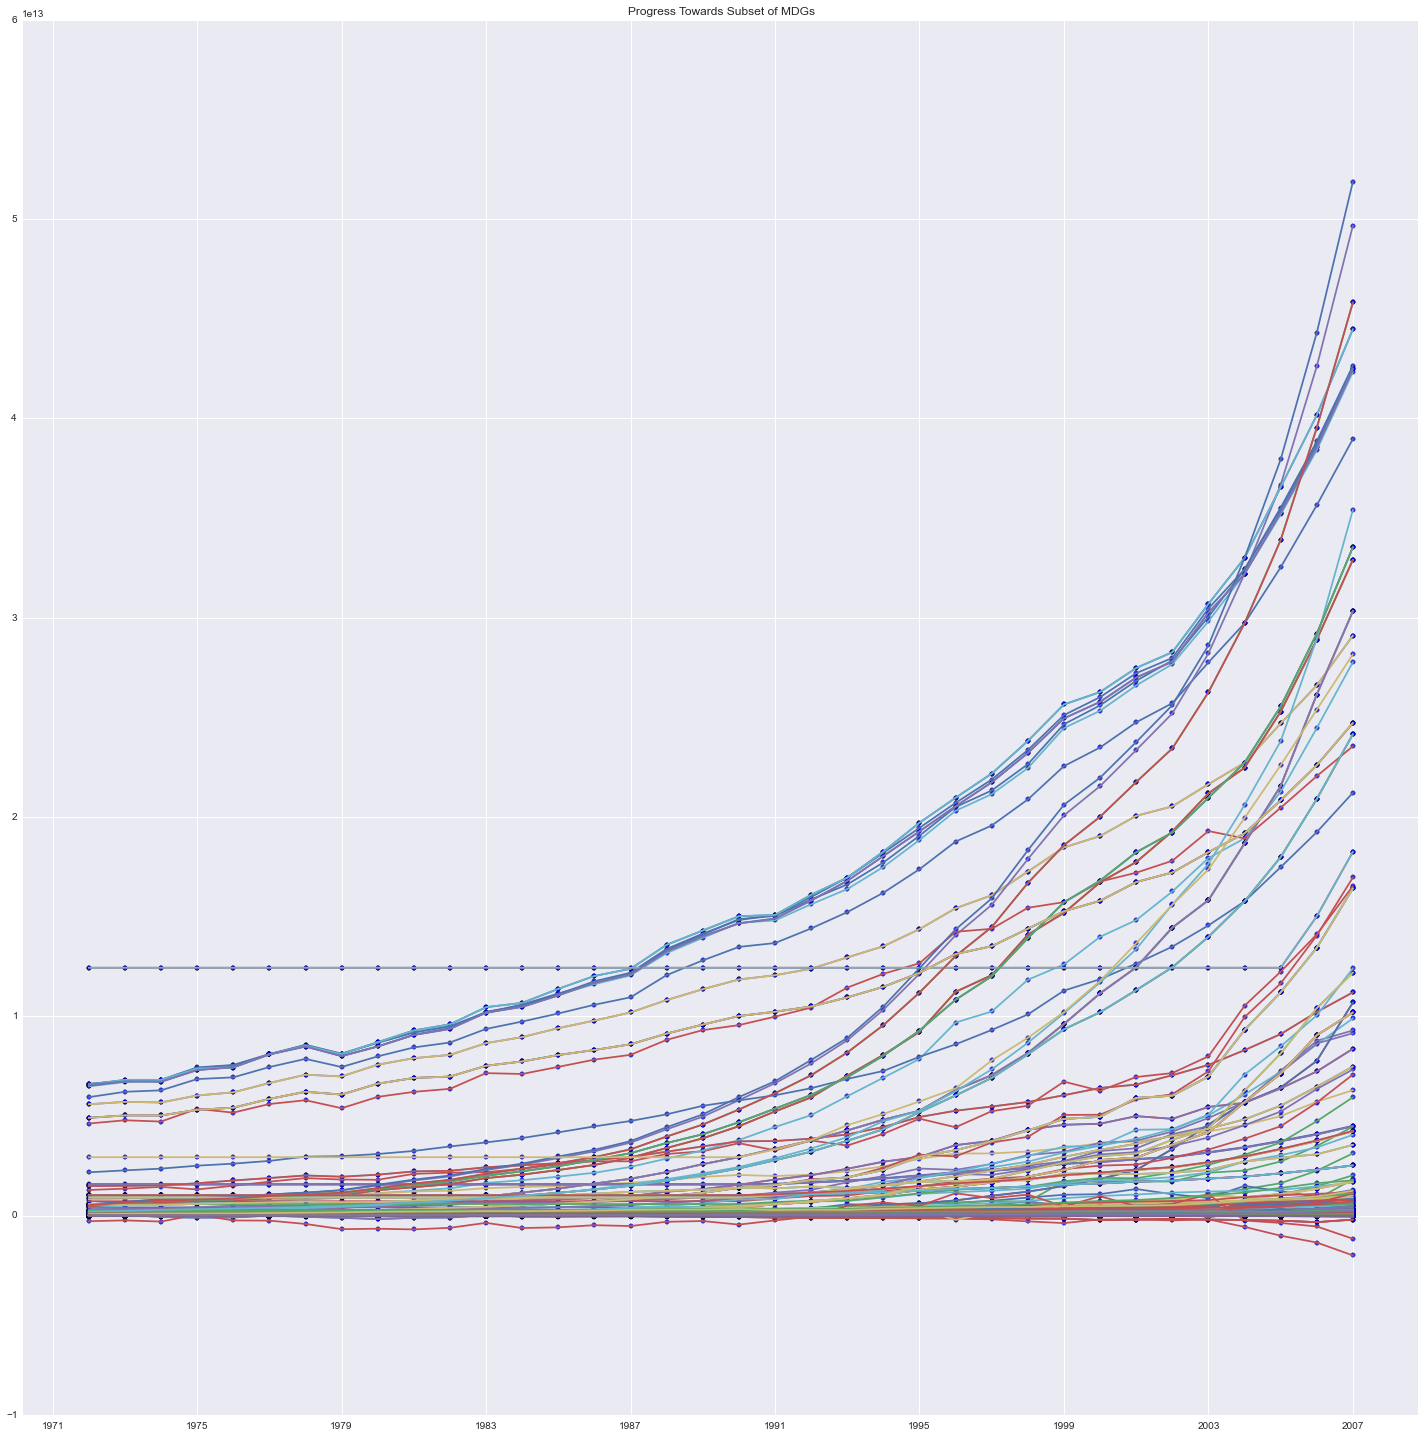

In [73]:
np.random.seed(100)
rand_rows = np.random.choice(indiarows.index.values, size=1240)

def plot_rows(data, ids=None, linestyle="-", legend=True):
    # get some colors for the lines
    bmap = pplt.brewer2mpl.get_map('Set3','Qualitative', 10, True)
    #colors = bmap.mpl_colors
    
    if not None == ids:
        get_rows = lambda: enumerate(ids)
    else:
        get_rows = lambda: enumerate(data.index.values)
    
    for i, r in get_rows():
        # get the time series values
        time_data = data.loc[r]

        # create an x axis to plot along
        just_years = [y[:4] for y in data.columns]
        X = pd.DatetimeIndex(just_years)

        # get time series info for labeling
        country, descrip = india2[["Country Name", "Series Name"]].loc[r]

        # plot the series
        plt.plot(X, time_data, 
                 label="{} - {}".format(country, descrip), ls=linestyle)
        plt.scatter(X, time_data, alpha=0.8)

#     if legend:
#         plt.legend(loc=0)
    plt.title("Progress Towards Subset of MDGs")

plot_rows(indiarows, ids=rand_rows)
plt.show()

In [74]:
india_pred_rows = india2.loc[submission_labels.index]

In [75]:
india_pred_rows = india_pred_rows[india_pred_rows["Country Name"] == "India"]
a=india_pred_rows[india_pred_rows.columns[:36]].values
#a

In [76]:
india_train = india2[~india2.index.isin(india_pred_rows.index.values)]
#india_train

In [77]:
india_test = india2[india2.index.isin(india_pred_rows.index.values)]
#india_test

In [78]:
india_pred_rows = india2.loc[submission_labels.index]
india_pred_rows = india_pred_rows[india_pred_rows["Country Name"] == "India"]
india_train = india2[~india2.index.isin(india_pred_rows.index.values)]
india_test = india2[india2.index.isin(india_pred_rows.index.values)]
india_test_index = india_test.index.values
india_train_index = india_train.index.values

In [79]:
snl1 = india_test.loc[india_test_index]
ara = snl1.values
ara=india_test[india_test.columns[:36]]
ara

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
115541          0.703         0.7030          0.703         0.7030   
115600          0.000         0.0000          0.000         0.0000   
115735          0.204         0.2002          0.196         0.1915   
116012          0.001         0.0010          0.001         0.0010   

        1976 [YR1976]  1977 [YR1977]  1978 [YR1978]  1979 [YR1979]  \
115541         0.7030         0.7030         0.7030         0.7030   
115600         0.0000         0.0000         0.0000         0.0000   
115735         0.1867         0.1817         0.1764         0.1713   
116012         0.0010         0.0010         0.0010         0.0010   

        1980 [YR1980]  1981 [YR1981]  1982 [YR1982]  1983 [YR1983]  \
115541         0.7030         0.7030         0.7030         0.7030   
115600         0.0000         0.0000         0.0000         0.0000   
115735         0.1663         0.1614         0.1569         0.1526   
116012         0.0010         0.0010         0.0010         0.0010   

        1984 [YR1984]  1985 [YR1985]  1986 [YR1986]  1987 [YR1987]  \
115541         0.7030         0.7030         0.7030         0.7030   
115600         0.0000         0.0000         0.0000         0.0000   
115735         0.1485         0.1445         0.1406         0.1367   
116012         0.0010         0.0010         0.0010         0.0010   

        1988 [YR1988]  1989 [YR1989]  1990 [YR1990]  1991 [YR1991]  \
115541         0.7030         0.7030         0.7030       0.714000   
115600         0.0000         0.0000         0.0000       0.000001   
115735         0.1329         0.1292         0.1256       0.122100   
116012         0.0010         0.0010         0.0010       0.001000   

        1992 [YR1992]  1993 [YR1993]  1994 [YR1994]  1995 [YR1995]  \
115541       0.724000       0.734000       0.745000       0.755000   
115600       0.000001       0.000002       0.000011       0.000262   
115735       0.118700       0.115400       0.112100       0.108800   
116012       0.001000       0.001000       0.001000       0.002000   

        1996 [YR1996]  1997 [YR1997]  1998 [YR1998]  1999 [YR1999]  \
115541       0.765000       0.776000        0.78600       0.796000   
115600       0.000463       0.000708        0.00139       0.002732   
115735       0.105500       0.102000        0.09850       0.095000   
116012       0.002000       0.003000        0.00300       0.004000   

        2000 [YR2000]  2001 [YR2001]  2002 [YR2002]  2003 [YR2003]  \
115541       0.806000       0.816000       0.827000       0.837000   
115600       0.005275       0.006601       0.015379       0.016865   
115735       0.091500       0.088100       0.084700       0.081300   
116012       0.004000       0.004000       0.004000       0.004000   

        2004 [YR2004]  2005 [YR2005]  2006 [YR2006]  2007 [YR2007]  
115541       0.847000       0.857000       0.867000         0.8770  
115600       0.019761       0.023881       0.028055         0.0395  
115735       0.078200       0.075100       0.072100         0.0693  
116012       0.004000       0.004000       0.004000         0.0030

In [80]:
snl2 = india_train.loc[india_train_index]
ara2 = snl2.values
#ara2.values
ara2=india_train[india_train.columns[:36]]
ara2

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
114990   1.072211e+01   1.072211e+01   1.072211e+01   1.072211e+01   
114991   3.998927e+01   3.998927e+01   3.998927e+01   3.998927e+01   
114992   2.840343e+01   2.840343e+01   2.840343e+01   2.840343e+01   
114993   3.995493e+00   3.995493e+00   3.995493e+00   3.995493e+00   
114994   1.466854e+01   1.466854e+01   1.466854e+01   1.466854e+01   
114995   1.560154e+01   1.560154e+01   1.560154e+01   1.560154e+01   
114996   6.860000e+01   6.860000e+01   6.860000e+01   6.860000e+01   
114998   7.824938e-01   7.824938e-01   7.824938e-01   7.824938e-01   
114999   6.611141e+01   6.611141e+01   6.611141e+01   6.611141e+01   
115000   8.952264e+01   8.952264e+01   8.952264e+01   8.952264e+01   
115001  -6.697895e-01   2.313600e+00  -1.531138e+00   6.592208e+00   
115002   1.396281e+11   1.428585e+11   1.406712e+11   1.499445e+11   
115003   6.563329e+10   7.828323e+10   9.029951e+10   8.772904e+10   
115004  -2.892019e+00   7.264818e-03  -3.767668e+00   4.154560e+00   
115005   2.404070e+02   2.404245e+02   2.313661e+02   2.409783e+02   
115006   1.130052e+02   1.317471e+02   1.485183e+02   1.409908e+02   
115007   7.396319e+00   7.396319e+00   7.396319e+00   7.396319e+00   
115008   7.389280e+09   7.389280e+09   7.389280e+09   7.389280e+09   
115009   1.046534e+01   1.046534e+01   1.046534e+01   1.046534e+01   
115010   3.374069e+10   3.374069e+10   3.374069e+10   3.374069e+10   
115011   4.436005e-01   4.074197e-01   3.990409e-01   4.852030e-01   
115012   3.208382e+08   3.528321e+08   4.026587e+08   4.847412e+08   
115013   7.216497e+00   6.914325e+00   7.479669e+00   8.051765e+00   
115014   5.219399e+09   5.987917e+09   7.547481e+09   8.044102e+09   
115015   2.410000e+00   2.418340e+00   2.561091e+00   2.209960e+00   
115016   1.743055e+09   2.094322e+09   2.584310e+09   2.207857e+09   
115017   2.103407e-01   2.453361e-01   6.697881e-01   1.119286e+00   
115018   1.521309e+08   2.124651e+08   6.758606e+08   1.118221e+09   
115019   1.785896e+01   1.785896e+01   1.785896e+01   1.785896e+01   
115020   1.366612e-01   1.174164e-01   1.478037e-01   2.041325e-01   
...               ...            ...            ...            ...   
116278   4.100000e+00   4.100000e+00   4.100000e+00   4.100000e+00   
116279   3.700000e+00   3.700000e+00   3.700000e+00   3.700000e+00   
116280   8.900000e+00   8.900000e+00   8.900000e+00   8.900000e+00   
116281   8.000000e+00   8.000000e+00   8.000000e+00   8.000000e+00   
116282   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116283   8.300000e+00   8.300000e+00   8.300000e+00   8.300000e+00   
116284   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116285   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116286   1.650000e+01   1.650000e+01   1.650000e+01   1.650000e+01   
116287   1.184179e+08   1.230170e+08   1.277875e+08   1.327346e+08   
116288   2.038880e+01   2.070320e+01   2.101760e+01   2.133200e+01   
116289   3.816655e+00   3.810233e+00   3.804689e+00   3.798258e+00   
116290   0.000000e+00   7.479700e+07   6.085150e+08   8.175230e+08   
116292   8.140000e+00   8.140000e+00   8.140000e+00   8.140000e+00   
116294   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116295   9.110000e+01   9.110000e+01   9.110000e+01   9.110000e+01   
116296   7.980000e+01   7.980000e+01   7.980000e+01   7.980000e+01   
116297   8.310000e+01   8.310000e+01   8.310000e+01   8.310000e+01   
116298   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116299   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116300   1.780000e+01   1.780000e+01   1.780000e+01   1.780000e+01   
116301   2.600000e+00   2.600000e+00   2.600000e+00   2.600000e+00   
116310   5.020092e-01   5.020092e-01   5.020092e-01   5.020092e-01   
116311   6.458208e+00   7.518547e+00   9.666839e+00   1.004536e+01   
116313   3.030000e+01   3.030000e+01   3.030000e+01   3.030000e+01   
116314   2.040000e

In [81]:
def window_matrix(av, win, overlap):
    l = range(len(av))
    windows = [av[s:e] for s,e in zip(l[::win-overlap], l[win::win-overlap])]
    return vstack(windows)
india_test_df = pd.DataFrame()
for ii in india_test_index:
    av = ara.loc[ii].values
    beta=window_matrix(av, 5,4)
    gamma = pd.DataFrame(beta)
    india_test_df = india_test_df.append(gamma, ignore_index = True)    
india_test_df.head()
india_test_df['mean'] = india_test_df.mean(axis=1)
india_test_df['std'] = india_test_df.std(axis=1)
def ent(value):
    entropy = - sum([ p * log(p) / log(2.0) for p in value])
    return entropy
india_test_df['entropy'] = india_test_df[:].apply(ent,axis=1)
india_test_df = india_test_df.fillna(0)
india_test_df.head(45)

0      1      2      3      4    mean       std   entropy
0   0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
1   0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
2   0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
3   0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
4   0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
5   0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
6   0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
7   0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
8   0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
9   0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
10  0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
11  0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
12  0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
13  0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
14  0.703  0.703  0.703  0.703  0.703  0.7030  0.000000  0.000000
15  0.703  0.703  0.703  0.703  0.714  0.7052  0.004400  2.166429
16  0.703  0.703  0.703  0.714  0.724  0.7094  0.008452  2.166161
17  0.703  0.703  0.714  0.724  0.734  0.7156  0.012076  2.149055
18  0.703  0.714  0.724  0.734  0.745  0.7240  0.014711  2.112501
19  0.714  0.724  0.734  0.745  0.755  0.7344  0.014568  2.050283
20  0.724  0.734  0.745  0.755  0.765  0.7446  0.014568  1.988650
21  0.734  0.745  0.755  0.765  0.776  0.7550  0.014711  1.925204
22  0.745  0.755  0.765  0.776  0.786  0.7654  0.014568  1.859236
23  0.755  0.765  0.776  0.786  0.796  0.7756  0.014568  1.793976
24  0.765  0.776  0.786  0.796  0.806  0.7858  0.014428  1.726917
25  0.776  0.786  0.796  0.806  0.816  0.7960  0.014142  1.658048
26  0.786  0.796  0.806  0.816  0.827  0.8062  0.014428  1.590650
27  0.796  0.806  0.816  0.827  0.837  0.8164  0.014568  1.521471
28  0.806  0.816  0.827  0.837  0.847  0.8266  0.014568  1.450550
29  0.816  0.827  0.837  0.847  0.857  0.8368  0.014428  1.377901
30  0.827  0.837  0.847  0.857  0.867  0.8470  0.014142  1.303511
31  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
32  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
33  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
34  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
35  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
36  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
37  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
38  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
39  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
40  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
41  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
42  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
43  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000
44  0.000  0.000  0.000  0.000  0.000  0.0000  0.000000  0.000000

In [82]:
india_test_col_reindex = [1, 2, 3, 'mean' , 'std' , 'entropy', 4]
india_test_df=india_test_df.reindex(columns = india_test_col_reindex)
india_test_df.head()

1      2      3   mean  std  entropy      4
0  0.703  0.703  0.703  0.703    0        0  0.703
1  0.703  0.703  0.703  0.703    0        0  0.703
2  0.703  0.703  0.703  0.703    0        0  0.703
3  0.703  0.703  0.703  0.703    0        0  0.703
4  0.703  0.703  0.703  0.703    0        0  0.703

In [83]:
len(india_train_index)

1236

In [84]:
def window_matrix(av, win, overlap):
    l = range(len(av))
    windows = [av[s:e] for s,e in zip(l[::win-overlap], l[win::win-overlap])]
    return vstack(windows)
india_train_df = pd.DataFrame()

for ii in india_train_index:
    av = ara2.loc[ii].values
    beta2 = window_matrix(av, 5,4)
    gamma2 = pd.DataFrame(beta2)
    india_train_df = india_train_df.append(gamma2, ignore_index = True)   
    
india_train_df.head()
india_train_df['mean'] = india_train_df.mean(axis=1)
india_train_df['std'] = india_train_df.std(axis=1)

def ent(value):
    entropy = - sum([ p * log(p) / log(2.0) for p in value])
    return entropy

india_train_df['entropy'] = india_train_df[:].apply(ent,axis=1)
india_train_df = india_train_df.fillna(0)
india_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38316 entries, 0 to 38315
Data columns (total 8 columns):
0          38316 non-null float64
1          38316 non-null float64
2          38316 non-null float64
3          38316 non-null float64
4          38316 non-null float64
mean       38316 non-null float64
std        38316 non-null float64
entropy    38316 non-null float64
dtypes: float64(8)
memory usage: 2.6 MB


In [85]:
india_train_col_reindex = [0,1, 2, 3, 'mean' , 'std' , 'entropy', 4]
india_train_df = india_train_df.reindex(columns = india_train_col_reindex)
india_train_df.tail(10)

0     1     2     3   mean       std      entropy     4
38306  31.0  31.7  32.4  32.9  32.28  0.851822  -970.718448  33.4
38307  31.7  32.4  32.9  33.4  32.86  0.765768  -993.113076  33.9
38308  32.4  32.9  33.4  33.9  33.38  0.679412 -1013.270507  34.3
38309  32.9  33.4  33.9  34.3  33.86  0.665132 -1032.015440  34.8
38310  33.4  33.9  34.3  34.8  34.32  0.636867 -1050.021399  35.2
38311  33.9  34.3  34.8  35.2  34.78  0.636867 -1068.107914  35.7
38312  34.3  34.8  35.2  35.7  35.22  0.636867 -1085.457409  36.1
38313  34.8  35.2  35.7  36.1  35.66  0.608605 -1102.829456  36.5
38314  35.2  35.7  36.1  36.5  36.06  0.567803 -1118.653428  36.8
38315  35.7  36.1  36.5  36.8  36.46  0.523832 -1134.518474  37.2

In [204]:
#Learning Model

In [86]:
X= india_train_df[india_train_df.columns[:6]]
y= india_train_df[india_train_df.columns[7]]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=.15, random_state=9)
linear_model1 = linear_model.Lasso(alpha = 1)
linear_model1.fit(X_train,y_train)
#linear_model1.predict(X_test)
model1_score = linear_model1.score(X_test, y_test)
model1_score

0.99933088807386261

In [87]:
x1 = range(1,100)
#x1=np.arange(.1,1,0.1)
y1=[]
for k in x1:
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=.35, random_state=k)
    score3 = linear_model1.score(X_test, y_test)
    y1.append(score3)
p = figure(title='Score Plot')
p.line(x1,y1,color='blue')
show(p)

In [90]:
linear_model1.score(X_test, y_test)

0.99964842585029257

In [91]:
y_pred =  linear_model1.predict(X_test)
y_true=np.array(y_test)
y_true

array([  2.24981207e+01,   6.99272000e+08,   5.39500000e+01, ...,
         4.47480000e+04,   8.31431098e+10,   5.40000000e-03])

In [94]:
r2_score(y_true, y_pred)

0.99964842585029257

In [95]:
mean_absolute_error(y_true, y_pred)

7597570002.4381056

In [96]:
mean_squared_error(y_true, y_pred)

1.6822922148283747e+21

In [97]:
median_absolute_error(y_true, y_pred)

3097212971.6397314

In [98]:
#confusion_matrix(y_pred, y_true)

In [99]:
score = cross_val_score(linear_model1, X_test, y_test, cv=5)
mean(score)

0.99964160140762548

In [100]:
linear_model3 = linear_model.ElasticNet(alpha = 1, l1_ratio=.5)
linear_model3.fit(X_train,y_train)
#linear_model1.predict(X_test)
model1_score3 = linear_model3.score(X_test, y_test)
model1_score3

0.99964654639972672

In [ ]:
#World

In [3]:
training_data.info(150)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195402 entries, 0 to 286117
Data columns (total 39 columns):
1972 [YR1972]    64945 non-null float64
1973 [YR1973]    64443 non-null float64
1974 [YR1974]    64966 non-null float64
1975 [YR1975]    66973 non-null float64
1976 [YR1976]    67717 non-null float64
1977 [YR1977]    69735 non-null float64
1978 [YR1978]    69763 non-null float64
1979 [YR1979]    69906 non-null float64
1980 [YR1980]    75250 non-null float64
1981 [YR1981]    78034 non-null float64
1982 [YR1982]    79016 non-null float64
1983 [YR1983]    78982 non-null float64
1984 [YR1984]    79532 non-null float64
1985 [YR1985]    81017 non-null float64
1986 [YR1986]    81455 non-null float64
1987 [YR1987]    82752 non-null float64
1988 [YR1988]    83242 non-null float64
1989 [YR1989]    86331 non-null float64
1990 [YR1990]    106955 non-null float64
1991 [YR1991]    106991 non-null float64
1992 [YR1992]    112243 non-null float64
1993 [YR1993]    114553 non-null float64
1994 

In [255]:
#training_data.head()

In [256]:
#Filling in all NaN Values using the values in adjacent cells, otherwise replacing NaN with 0

In [4]:
world = training_data
world.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195402 entries, 0 to 286117
Data columns (total 39 columns):
1972 [YR1972]    64945 non-null float64
1973 [YR1973]    64443 non-null float64
1974 [YR1974]    64966 non-null float64
1975 [YR1975]    66973 non-null float64
1976 [YR1976]    67717 non-null float64
1977 [YR1977]    69735 non-null float64
1978 [YR1978]    69763 non-null float64
1979 [YR1979]    69906 non-null float64
1980 [YR1980]    75250 non-null float64
1981 [YR1981]    78034 non-null float64
1982 [YR1982]    79016 non-null float64
1983 [YR1983]    78982 non-null float64
1984 [YR1984]    79532 non-null float64
1985 [YR1985]    81017 non-null float64
1986 [YR1986]    81455 non-null float64
1987 [YR1987]    82752 non-null float64
1988 [YR1988]    83242 non-null float64
1989 [YR1989]    86331 non-null float64
1990 [YR1990]    106955 non-null float64
1991 [YR1991]    106991 non-null float64
1992 [YR1992]    112243 non-null float64
1993 [YR1993]    114553 non-null float64
1994 

In [5]:
world_data = pd.read_csv("TrainingSet.csv", index_col=0)
world_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195402 entries, 0 to 286117
Data columns (total 39 columns):
1972 [YR1972]    64945 non-null float64
1973 [YR1973]    64443 non-null float64
1974 [YR1974]    64966 non-null float64
1975 [YR1975]    66973 non-null float64
1976 [YR1976]    67717 non-null float64
1977 [YR1977]    69735 non-null float64
1978 [YR1978]    69763 non-null float64
1979 [YR1979]    69906 non-null float64
1980 [YR1980]    75250 non-null float64
1981 [YR1981]    78034 non-null float64
1982 [YR1982]    79016 non-null float64
1983 [YR1983]    78982 non-null float64
1984 [YR1984]    79532 non-null float64
1985 [YR1985]    81017 non-null float64
1986 [YR1986]    81455 non-null float64
1987 [YR1987]    82752 non-null float64
1988 [YR1988]    83242 non-null float64
1989 [YR1989]    86331 non-null float64
1990 [YR1990]    106955 non-null float64
1991 [YR1991]    106991 non-null float64
1992 [YR1992]    112243 non-null float64
1993 [YR1993]    114553 non-null float64
1994 

In [6]:
world_data[world_data.columns[:36]] = world_data[world_data.columns[:36]].fillna(method = 'bfill', axis = 1)
world_data[world_data.columns[:36]] = world_data[world_data.columns[:36]].fillna(method = 'ffill', axis = 1)
world_data.tail()

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
286113           12.0           12.0           12.0           12.0   
286114           27.8           27.8           27.8           27.8   
286115           31.2           31.2           31.2           31.2   
286116           22.3           22.3           22.3           22.3   
286117           54.5           54.5           54.5           54.5   

        1976 [YR1976]  1977 [YR1977]  1978 [YR1978]  1979 [YR1979]  \
286113           12.0           12.0           12.0           12.0   
286114           27.8           27.8           27.8           27.8   
286115           31.2           31.2           31.2           31.2   
286116           22.3           22.3           22.3           22.3   
286117           54.5           54.5           54.5           54.5   

        1980 [YR1980]  1981 [YR1981]  1982 [YR1982]  1983 [YR1983]  \
286113           12.0           12.0           12.0           12.0   
286114           27.8           27.8           27.8           27.8   
286115           31.2           31.2           31.2           31.2   
286116           22.3           22.3           22.3           22.3   
286117           54.5           54.5           54.5           54.5   

        1984 [YR1984]  1985 [YR1985]  1986 [YR1986]  1987 [YR1987]  \
286113           12.0           12.0           12.0           12.0   
286114           27.8           27.8           27.8           27.8   
286115           31.2           31.2           31.2           31.2   
286116           22.3           22.3           22.3           22.3   
286117           54.5           54.5           54.5           54.5   

        1988 [YR1988]  1989 [YR1989]  1990 [YR1990]  1991 [YR1991]  \
286113           12.0           12.0           12.0           12.0   
286114           27.8           27.8           27.8           27.8   
286115           31.2           31.2           31.2           31.2   
286116           22.3           22.3           22.3           22.3   
286117           54.5           54.5           54.5           55.1   

        1992 [YR1992]  1993 [YR1993]  1994 [YR1994]  1995 [YR1995]  \
286113           12.0           12.0           12.0           12.0   
286114           27.8           27.8           27.8           27.8   
286115           31.2           31.2           31.2           31.2   
286116           22.3           22.3           22.3           22.3   
286117           55.5           55.8           56.0           56.1   

        1996 [YR1996]  1997 [YR1997]  1998 [YR1998]  1999 [YR1999]  \
286113           12.0           12.0           12.0           12.0   
286114           27.8           27.8           27.8           27.8   
286115           31.2           31.2           31.2           31.2   
286116           22.3           22.3           22.3           22.3   
286117           56.3           56.4           56.5           56.7   

        2000 [YR2000]  2001 [YR2001]  2002 [YR2002]  2003 [YR2003]  \
286113           12.2           12.2           12.2           12.2   
286114           33.0           33.0           33.0           33.0   
286115           30.2           30.2           30.2           30.2   
286116           24.3           24.3           24.3           24.3   
286117           56.8           57.0           57.2           57.5   

        2004 [YR2004]  2005 [YR2005]  2006 [YR2006]  2007 [YR2007]  \
286113           12.2           12.2           12.2           12.2   
286114           33.0           33.0           33.0           33.0   
286115           30.2           30.2           30.2           30.2   
286116           24.3           24.3           24.3           24.3   
286117           57.7           57.9           58.1           58.3   

       Country Name        Series Code  \
286113     Zimbabwe     SG.VAW.BURN.ZS   
286114     Zimbabwe     SG.VAW.GOES.ZS   
286115     Zimbabwe     SG.VAW.NEGL.ZS   
286116     Zimbabwe     SG.VAW.REFU.ZS   
286117   

In [7]:
world_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195402 entries, 0 to 286117
Data columns (total 39 columns):
1972 [YR1972]    195402 non-null float64
1973 [YR1973]    195402 non-null float64
1974 [YR1974]    195402 non-null float64
1975 [YR1975]    195402 non-null float64
1976 [YR1976]    195402 non-null float64
1977 [YR1977]    195402 non-null float64
1978 [YR1978]    195402 non-null float64
1979 [YR1979]    195402 non-null float64
1980 [YR1980]    195402 non-null float64
1981 [YR1981]    195402 non-null float64
1982 [YR1982]    195402 non-null float64
1983 [YR1983]    195402 non-null float64
1984 [YR1984]    195402 non-null float64
1985 [YR1985]    195402 non-null float64
1986 [YR1986]    195402 non-null float64
1987 [YR1987]    195402 non-null float64
1988 [YR1988]    195402 non-null float64
1989 [YR1989]    195402 non-null float64
1990 [YR1990]    195402 non-null float64
1991 [YR1991]    195402 non-null float64
1992 [YR1992]    195402 non-null float64
1993 [YR1993]    195402 non-

In [8]:
worldrows = world_data.loc[world_data.index]
worldrows.describe()

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
count   1.954020e+05   1.954020e+05   1.954020e+05   1.954020e+05   
mean    1.309545e+11   1.374147e+11   1.462164e+11   1.503911e+11   
std     5.749561e+12   5.870438e+12   6.053093e+12   6.160588e+12   
min    -1.047939e+14  -1.128889e+14  -7.134161e+13  -8.269588e+13   
25%     3.963520e+00   4.000000e+00   4.048369e+00   4.056275e+00   
50%     3.873340e+01   3.932200e+01   4.019937e+01   4.043348e+01   
75%     6.500000e+04   7.688325e+04   9.553064e+04   1.061118e+05   
max     8.601507e+14   8.601507e+14   8.601507e+14   8.601507e+14   

       1976 [YR1976]  1977 [YR1977]  1978 [YR1978]  1979 [YR1979]  \
count   1.954020e+05   1.954020e+05   1.954020e+05   1.954020e+05   
mean    1.571871e+11   1.631184e+11   1.676842e+11   1.746394e+11   
std     6.324943e+12   6.452702e+12   6.565505e+12   6.753754e+12   
min    -9.735652e+13  -9.433422e+13  -9.495898e+13  -5.362479e+13   
25%     4.209674e+00   4.301007e+00   4.381298e+00   4.416568e+00   
50%     4.099462e+01   4.158190e+01   4.210000e+01   4.249324e+01   
75%     1.200000e+05   1.426405e+05   1.719388e+05   1.870252e+05   
max     8.601507e+14   8.601507e+14   8.601507e+14   8.601507e+14   

       1980 [YR1980]  1981 [YR1981]  1982 [YR1982]  1983 [YR1983]  \
count   1.954020e+05   1.954020e+05   1.954020e+05   1.954020e+05   
mean    1.793396e+11   1.869089e+11   1.912938e+11   1.989030e+11   
std     6.926447e+12   7.224099e+12   7.348624e+12   7.585365e+12   
min    -5.649790e+13  -5.437839e+13  -3.426626e+13  -5.200444e+13   
25%     4.500000e+00   4.530362e+00   4.500000e+00   4.509015e+00   
50%     4.310000e+01   4.330000e+01   4.360000e+01   4.390000e+01   
75%     2.249795e+05   2.346472e+05   2.507790e+05   2.700780e+05   
max     8.601507e+14   8.601507e+14   8.601507e+14   8.601507e+14   

       1984 [YR1984]  1985 [YR1985]  1986 [YR1986]  1987 [YR1987]  \
count   1.954020e+05   1.954020e+05   1.954020e+05   1.954020e+05   
mean    2.058095e+11   2.131182e+11   2.191229e+11   2.296361e+11   
std     7.818417e+12   8.083852e+12   8.282166e+12   8.593737e+12   
min    -3.946788e+13  -3.687346e+13  -3.562521e+13  -3.890910e+13   
25%     4.622513e+00   4.585782e+00   4.644527e+00   4.600000e+00   
50%     4.404964e+01   4.416097e+01   4.449215e+01   4.458277e+01   
75%     2.780000e+05   2.844553e+05   3.000000e+05   2.999872e+05   
max     8.601507e+14   8.601507e+14   8.601507e+14   8.601507e+14   

       1988 [YR1988]  1989 [YR1989]  1990 [YR1990]  1991 [YR1991]  \
count   1.954020e+05   1.954020e+05   1.954020e+05   1.954020e+05   
mean    2.389751e+11   2.551253e+11   2.756764e+11   2.963752e+11   
std     8.891027e+12   9.466777e+12   1.017278e+13   1.077641e+13   
min    -6.349069e+13  -5.612962e+13  -4.287495e+13  -5.221512e+13   
25%     4.690557e+00   4.670436e+00   4.709299e+00   4.600000e+00   
50%     4.480000e+01   4.504024e+01   4.520000e+01   4.507114e+01   
75%     3.000000e+05   3.108278e+05   3.247865e+05   3.147492e+05   
max     8.865110e+14   9.735230e+14   1.047622e+15   1.097263e+15   

       1992 [YR1992]  1993 [YR1993]  1994 [YR1994]  1995 [YR1995]  \
count   1.954020e+05   1.954020e+05   1.954020e+05   1.954020e+05   
mean    3.146771e+11   3.356569e+11   3.627173e+11   3.965411e+11   
std     1.131872e+13   1.197222e+13   1.279708e+13   1.382114e+13   
min    -5.054790e+13  -7.303608e+13  -6.360371e+13  -7.682327e+13   
25%     4.651173e+00   4.700000e+00   4.851361e+00   5.000000e+00   
50%     4.530000e+01   4.573548e+01   4.610000e+01   4.659137e+01   
75%     3.213975e+05   3.494255e+05   4.000000e+05   4.700000e+05   
max     1.153124e+15   1.192591e+15   1.238312e+15   1.342285e+15   

       1996 [YR1996]  1997 [YR1997]  1998 [YR1998]  1999 [YR1999]  \
count   1.954020e+05   1.954020e+05   1.954020e+05   1.954020e+05   
mean    4.316733e+11   4.646513e+11   4.844642e+11   5.112024e+11   
std     1.486737e+13   1.574628e+13   1.582064e+13   1.649811e+13   

In [9]:
worldrows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195402 entries, 0 to 286117
Data columns (total 39 columns):
1972 [YR1972]    195402 non-null float64
1973 [YR1973]    195402 non-null float64
1974 [YR1974]    195402 non-null float64
1975 [YR1975]    195402 non-null float64
1976 [YR1976]    195402 non-null float64
1977 [YR1977]    195402 non-null float64
1978 [YR1978]    195402 non-null float64
1979 [YR1979]    195402 non-null float64
1980 [YR1980]    195402 non-null float64
1981 [YR1981]    195402 non-null float64
1982 [YR1982]    195402 non-null float64
1983 [YR1983]    195402 non-null float64
1984 [YR1984]    195402 non-null float64
1985 [YR1985]    195402 non-null float64
1986 [YR1986]    195402 non-null float64
1987 [YR1987]    195402 non-null float64
1988 [YR1988]    195402 non-null float64
1989 [YR1989]    195402 non-null float64
1990 [YR1990]    195402 non-null float64
1991 [YR1991]    195402 non-null float64
1992 [YR1992]    195402 non-null float64
1993 [YR1993]    195402 non-

In [10]:
worldrows.head()

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  1976 [YR1976]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   1977 [YR1977]  1978 [YR1978]  1979 [YR1979]  1980 [YR1980]  1981 [YR1981]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   1982 [YR1982]  1983 [YR1983]  1984 [YR1984]  1985 [YR1985]  1986 [YR1986]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   1987 [YR1987]  1988 [YR1988]  1989 [YR1989]  1990 [YR1990]  1991 [YR1991]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   1992 [YR1992]  1993 [YR1993]  1994 [YR1994]  1995 [YR1995]  1996 [YR1996]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   1997 [YR1997]  1998 [YR1998]  1999 [YR1999]  2000 [YR2000]  2001 [YR2001]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   2002 [YR2002]  2003 [YR2003]  2004 [YR2004]  2005 [YR2005]  2006 [YR2006]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   2007 [YR2007] Country Name    Series Code  \
0       3.769214  Afghanistan    allsi.bi_q1   
1       7.027746  Afghanistan    allsp.bi_q1   
2       8.244887  Afghanistan    allsa.bi_q1   
4      12.933105  Afghanistan  allsi.gen_pop   
5      18.996814  Afghanistan  allsp.gen_pop   

                                         Series Name  
0  (%) Benefits held by 1st 20% population - All ...  
1  (%) Benefits held by 1st 20% population - All ...  
2  (%) Benefits held by 1st 20% population - All ...  
4             (%) Generosity of All Social Insurance  
5            (%) Generosity of All Social Protection

In [264]:
#All null values have been replaced with a non-null float64 object

In [11]:
len(unique(world_data.index))

195402

In [12]:
len(world_data.index)

195402

In [13]:
world_data_index = world_data.index.values
world_data_index

array([     0,      1,      2, ..., 286115, 286116, 286117], dtype=int64)

In [14]:
len(world_data_index)

195402

In [15]:
worldara=world_data[world_data.columns[:36]]
worldara.head()

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  1976 [YR1976]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   1977 [YR1977]  1978 [YR1978]  1979 [YR1979]  1980 [YR1980]  1981 [YR1981]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   1982 [YR1982]  1983 [YR1983]  1984 [YR1984]  1985 [YR1985]  1986 [YR1986]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   1987 [YR1987]  1988 [YR1988]  1989 [YR1989]  1990 [YR1990]  1991 [YR1991]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   1992 [YR1992]  1993 [YR1993]  1994 [YR1994]  1995 [YR1995]  1996 [YR1996]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   1997 [YR1997]  1998 [YR1998]  1999 [YR1999]  2000 [YR2000]  2001 [YR2001]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   2002 [YR2002]  2003 [YR2003]  2004 [YR2004]  2005 [YR2005]  2006 [YR2006]  \
0       3.769214       3.769214       3.769214       3.769214       3.769214   
1       7.027746       7.027746       7.027746       7.027746       7.027746   
2       8.244887       8.244887       8.244887       8.244887       8.244887   
4      12.933105      12.933105      12.933105      12.933105      12.933105   
5      18.996814      18.996814      18.996814      18.996814      18.996814   

   2007 [YR2007]  
0       3.769214  
1       7.027746  
2       8.244887  
4      12.933105  
5      18.996814

In [16]:
worldara.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195402 entries, 0 to 286117
Data columns (total 36 columns):
1972 [YR1972]    195402 non-null float64
1973 [YR1973]    195402 non-null float64
1974 [YR1974]    195402 non-null float64
1975 [YR1975]    195402 non-null float64
1976 [YR1976]    195402 non-null float64
1977 [YR1977]    195402 non-null float64
1978 [YR1978]    195402 non-null float64
1979 [YR1979]    195402 non-null float64
1980 [YR1980]    195402 non-null float64
1981 [YR1981]    195402 non-null float64
1982 [YR1982]    195402 non-null float64
1983 [YR1983]    195402 non-null float64
1984 [YR1984]    195402 non-null float64
1985 [YR1985]    195402 non-null float64
1986 [YR1986]    195402 non-null float64
1987 [YR1987]    195402 non-null float64
1988 [YR1988]    195402 non-null float64
1989 [YR1989]    195402 non-null float64
1990 [YR1990]    195402 non-null float64
1991 [YR1991]    195402 non-null float64
1992 [YR1992]    195402 non-null float64
1993 [YR1993]    195402 non-

In [17]:
unique(world_data_index)

array([     0,      1,      2, ..., 286115, 286116, 286117], dtype=int64)

In [18]:
world_snl = world_data.loc[world_data_index]
araw = world_snl.values
araw=world_data[world_data.columns[:36]]
araw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195402 entries, 0 to 286117
Data columns (total 36 columns):
1972 [YR1972]    195402 non-null float64
1973 [YR1973]    195402 non-null float64
1974 [YR1974]    195402 non-null float64
1975 [YR1975]    195402 non-null float64
1976 [YR1976]    195402 non-null float64
1977 [YR1977]    195402 non-null float64
1978 [YR1978]    195402 non-null float64
1979 [YR1979]    195402 non-null float64
1980 [YR1980]    195402 non-null float64
1981 [YR1981]    195402 non-null float64
1982 [YR1982]    195402 non-null float64
1983 [YR1983]    195402 non-null float64
1984 [YR1984]    195402 non-null float64
1985 [YR1985]    195402 non-null float64
1986 [YR1986]    195402 non-null float64
1987 [YR1987]    195402 non-null float64
1988 [YR1988]    195402 non-null float64
1989 [YR1989]    195402 non-null float64
1990 [YR1990]    195402 non-null float64
1991 [YR1991]    195402 non-null float64
1992 [YR1992]    195402 non-null float64
1993 [YR1993]    195402 non-

In [19]:
def world_matrix(avw, win, overlap):
    l = range(len(avw))
    windows = [avw[s:e] for s,e in zip(l[::win-overlap], l[win::win-overlap])]
    return vstack(windows)

In [26]:
world_data_df = pd.DataFrame()
for i in world_data_index:
    avw = araw.loc[i].values
    beta3 = world_matrix(avw,5,4)
    gamma3 = pd.DataFrame(beta3)
    world_data_df = world_data_df.append(gamma3, ignore_index = True) 
world_data_df.head()

0         1         2         3         4
0  3.769214  3.769214  3.769214  3.769214  3.769214
1  3.769214  3.769214  3.769214  3.769214  3.769214
2  3.769214  3.769214  3.769214  3.769214  3.769214
3  3.769214  3.769214  3.769214  3.769214  3.769214
4  3.769214  3.769214  3.769214  3.769214  3.769214

In [22]:
world_data_df.head()

0         1         2         3         4
0  3.769214  3.769214  3.769214  3.769214  3.769214
1  3.769214  3.769214  3.769214  3.769214  3.769214
2  3.769214  3.769214  3.769214  3.769214  3.769214
3  3.769214  3.769214  3.769214  3.769214  3.769214
4  3.769214  3.769214  3.769214  3.769214  3.769214

In [27]:
world_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6057462 entries, 0 to 6057461
Data columns (total 5 columns):
0    float64
1    float64
2    float64
3    float64
4    float64
dtypes: float64(5)
memory usage: 277.3 MB


In [30]:
6057462 / 195402

31

In [29]:
#world_data_df.head()
world_data_df['mean'] = world_data_df.mean(axis=1)
world_data_df['std'] = world_data_df.std(axis=1)
def ent(value):
    entropy = - sum([ p * log(p) / log(2.0) for p in value])
    return entropy
world_data_df['entropy'] = world_data_df[:].apply(ent,axis=1)
world_data_df = world_data_df.fillna(0)
world_data_df.describe()

world_data_col_reindex = [0, 1, 2, 3, 'mean' , 'std' , 'entropy', 4]
world_data_df = world_data_df.reindex(columns = world_data_col_reindex)
world_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6057462 entries, 0 to 6057461
Data columns (total 8 columns):
0          float64
1          float64
2          float64
3          float64
mean       float64
std        float64
entropy    float64
4          float64
dtypes: float64(8)
memory usage: 415.9 MB


In [48]:
Xw= world_data_df[world_data_df.columns[:6]]
yw= world_data_df[world_data_df.columns[7]]
Xw_train, Xw_test, yw_train, yw_test = cross_validation.train_test_split(Xw, yw, test_size=.15, random_state=9)
linear_modelw = linear_model.Lasso(alpha = 1)
linear_modelw.fit(Xw_train,yw_train)
#linear_modelw.predict(Xw_test)
model1w_score = linear_modelw.score(Xw_test, yw_test)
model1w_score

0.9949544022682475

In [ ]:
xw1 = range(1,100)
#x1=np.arange(.1,1,0.1)
yw1=[]
for k in xw1:
    Xw_train, Xw_test, yw_train, yw_test = cross_validation.train_test_split(Xw, yw, test_size=.35, random_state=k)
    score1w = linear_modelw.score(Xw_test, yw_test)
    y1.append(score1w)
p = figure(title='Score Plot')
p.line(xw1,yw1,color='blue')
show(p)

In [32]:
yw_pred =  linear_modelw.predict(Xw_test)
yw_true=np.array(yw_test)
#yw_true

In [33]:
r2_score(yw_true, yw_pred)

0.88321656765818712

In [34]:
mean_absolute_error(yw_true, yw_pred)

28406623799582.215

In [35]:
mean_squared_error(yw_true, yw_pred)

1.4251409932782949e+30

In [36]:
score3w = cross_val_score(linear_modelw, Xw_test, yw_test, cv=5)
score3w

array([ 0.88765911,  0.79344969,  0.83869713,  0.90564725,  0.92734353])

In [39]:
mean(score3w)

0.87055933977733191

In [38]:
linear_model2w = linear_model.ElasticNet(alpha = 1, l1_ratio=.5)
linear_model2w.fit(Xw_train,yw_train)
model1_score2w = linear_model2w.score(Xw_test, yw_test)
model1_score2w


0.88321656765818712

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [46]:
fit_data = MinMaxScaler().fit_transform(world_data_df)
normworld_data_df = pd.DataFrame(world_data_df, columns=world_data_df.columns)
normworld_data_df.describe()


0             1             2             3          mean  \
count  6.057462e+06  6.057462e+06  6.057462e+06  6.057462e+06  6.057462e+06   
mean   2.926014e+11  3.115879e+11  3.329642e+11  3.569805e+11  3.356698e+11   
std    1.126562e+13  1.192353e+13  1.269414e+13  1.360757e+13  1.277035e+13   
min   -1.128889e+14 -1.853552e+14 -1.853552e+14 -1.853552e+14 -1.029093e+14   
25%    4.570853e+00  4.601066e+00  4.663822e+00  4.700000e+00  5.020000e+00   
50%    4.420000e+01  4.453224e+01  4.487576e+01  4.512788e+01  4.688014e+01   
75%    2.600000e+05  2.800000e+05  3.000000e+05  3.165190e+05  4.952000e+05   
max    1.821833e+15  2.013675e+15  2.295826e+15  2.774281e+15  2.448966e+15   

                std       entropy             4  
count  6.057462e+06  6.057462e+06  6.057462e+06  
mean   3.840140e+10 -8.499098e+13  3.842152e+11  
std    1.785654e+12  3.627813e+15  1.469566e+13  
min    0.000000e+00 -7.784551e+17 -1.853552e+14  
25%    0.000000e+00 -3.764055e+03  4.740580e+00  
50%    4.363743e-03 -2.352457e+01  4.540000e+01  
75%    1.234406e+01  0.000000e+00  3.333739e+05  
max    5.560521e+14  3.429953e+00  3.339217e+15

In [47]:
nXw= normworld_data_df[normworld_data_df.columns[:6]]
nyw= normworld_data_df[normworld_data_df.columns[7]]
nXw_train, nXw_test, nyw_train, nyw_test = cross_validation.train_test_split(nXw, nyw, test_size=.15, random_state=9)
linear_modelnw = linear_model.Lasso(alpha = 1)
linear_modelnw.fit(nXw_train,nyw_train)
#linear_modelw.predict(Xw_test)
model1nw_score = linear_modelnw.score(nXw_test, nyw_test)
model1nw_score

0.9949544022682475

In [49]:
Sfit_data = StandardScaler().fit_transform(world_data_df)
Snormworld_data_df = pd.DataFrame(world_data_df, columns=world_data_df.columns)
Snormworld_data_df.describe()


0             1             2             3          mean  \
count  6.057462e+06  6.057462e+06  6.057462e+06  6.057462e+06  6.057462e+06   
mean   2.926014e+11  3.115879e+11  3.329642e+11  3.569805e+11  3.356698e+11   
std    1.126562e+13  1.192353e+13  1.269414e+13  1.360757e+13  1.277035e+13   
min   -1.128889e+14 -1.853552e+14 -1.853552e+14 -1.853552e+14 -1.029093e+14   
25%    4.570853e+00  4.601066e+00  4.663822e+00  4.700000e+00  5.020000e+00   
50%    4.420000e+01  4.453224e+01  4.487576e+01  4.512788e+01  4.688014e+01   
75%    2.600000e+05  2.800000e+05  3.000000e+05  3.165190e+05  4.952000e+05   
max    1.821833e+15  2.013675e+15  2.295826e+15  2.774281e+15  2.448966e+15   

                std       entropy             4  
count  6.057462e+06  6.057462e+06  6.057462e+06  
mean   3.840140e+10 -8.499098e+13  3.842152e+11  
std    1.785654e+12  3.627813e+15  1.469566e+13  
min    0.000000e+00 -7.784551e+17 -1.853552e+14  
25%    0.000000e+00 -3.764055e+03  4.740580e+00  
50%    4.363743e-03 -2.352457e+01  4.540000e+01  
75%    1.234406e+01  0.000000e+00  3.333739e+05  
max    5.560521e+14  3.429953e+00  3.339217e+15

In [52]:
snXw= Snormworld_data_df[Snormworld_data_df.columns[:6]]
snyw= Snormworld_data_df[Snormworld_data_df.columns[7]]
snXw_train, snXw_test, snyw_train, snyw_test = cross_validation.train_test_split(snXw, snyw, test_size=.35, random_state=9)
linear_modelsnw = linear_model.Lasso(alpha = 1)
linear_modelsnw.fit(snXw_train,snyw_train)
#linear_modelw.predict(Xw_test)
model1snw_score = linear_modelsnw.score(snXw_test, snyw_test)
model1snw_score

0.99606870805915804